## Shenick LOG分析脚本
---
**环境**：
- Python 3.5+
- pandas 0.18.1
- matlibplot 2.0.0
- numpy 1.11.3+mkl

**功能**
- 统计VoLTE信息

**限制**
- TODO

**历史**
- 0.01: 2017/07/27
- 0.02: 增加对VoLTE语音速率的统计

**TO DO**
- 增加对多DRB应用的支持
- 增加对ping应用的处理
- 简化FTP log code

### 导入相关模块，定义Log文件路径和公共函数

In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import warnings
warnings.filterwarnings('ignore')

# Shenick Log所在路径
log_path = r"D:\userdata\anliu\Desktop\log\0802\10MHz_IB\Shenick" 

### VoLTE统计信息

In [2]:
def volte_process():
    # 读取Log文件，如果文件不存在返回打印信息
    file_path = os.path.join(log_path, "Application")  
    try: 
        os.chdir(file_path)
    except:
        print("The folder does not exist!")
        return
    volte_logs = glob.glob("./cvoip*.csv")
    if volte_logs:
        print("Start to analyze VoLTE log...")
    else:
        print("no VoLTE log!")
        return  
    
    # 统计VoLTE UE ID，MOS值，Jitter值，Packet Loss Rate（PLR）和Volte失败的UE数，以及主被叫收发包速率即AMR-WB/AMR-NB的速率
    volte_total_num = 0
    volte_ue_id = []
    volte_mos = []
    volte_jitter = []
    volte_plr = []
    volte_delay = []
    volte_fail = []
    volte_caller_out_rate = []
    volte_caller_in_rate = []
    volte_callee_out_rate = []
    volte_callee_in_rate = []
    
    for log in volte_logs:
        p = re.search(r'_(\d+)_', log)
        ue_id = p.group(1)
        volte_ue_id.append(ue_id)
        
        df_log = pd.read_csv(log, low_memory=False, skip_blank_lines=True, na_values=['nan']) 
        # 如果In Service值的和等于0，说明该VoLTE应用没有被调用，不统计
        if (df_log['In Service'].sum() == 0):
            continue
        volte_total_num += 1
        # 尽量避免使用dataframe的hard copy，这是一件非常占用资源和时间的做法，可以对比下面code和上面的code，实现类似的功能，下面的做法需要花费更多的时间
#         df_log = df_log[df_log['In Service']==1]
#         if df_log.empty:
#             continue
#         volte_total_num += 1

        # 'RTP Mean Latency ms'统计开关不是默认开启。如果开关没有开启，增加'RTP Mean Latency ms'列并取值为0
        if ('RTP Mean Latency ms') not in df_log:
            df_log['RTP Mean Latency ms'] = 0        
        df_log.dropna(axis=0, subset=['QmVoice MOS','QmVoice Discarded Packets', 'QmVoice In Packets','RTP Jitter (RFC3550) ms'], inplace=True)
        
        # 'RTP Mean Latency ms'统计只对主叫有效
        if (int(ue_id)%2) == 0:
            delay = df_log['RTP Mean Latency ms'].mean()
            if np.isnan(delay):
                delay = 0
            volte_delay.append(delay)

            # 主叫语音速率               
            caller_out_rate = df_log['Out RTP Bits/s'].mean()
            caller_in_rate = df_log['In RTP Bits/s'].mean()            
            volte_caller_out_rate.append(caller_out_rate)
            volte_caller_in_rate.append(caller_in_rate)
        else:
            callee_out_rate = df_log['Out RTP Bits/s'].mean()
            callee_in_rate = df_log['In RTP Bits/s'].mean()
            # 被叫语音速率
            volte_callee_out_rate.append(callee_out_rate)
            volte_callee_in_rate.append(callee_in_rate)
        
        # MOS/Jitter/PLR
        mos = df_log['QmVoice MOS'].mean()
        jitter = df_log["RTP Jitter (RFC3550) ms"].mean()
        plr = df_log['QmVoice Discarded Packets'].mean()/df_log['QmVoice In Packets'].mean()*100
        
        # 如果MOS值不存在，说明VoLTE call失败
        if np.isnan(mos): 
            volte_fail.append(ue_id)
        
        volte_mos.append(mos)
        volte_jitter.append(jitter)
        volte_plr.append(plr)

    
    # 统计平均值的时候去掉VoLTE失败的UE
    mos_avg = np.nanmean(volte_mos)
    jitter_avg = np.nanmean(volte_jitter)
    plr_avg = np.nanmean(volte_plr)
    delay_avg = np.nanmean(volte_delay)
    
    caller_out_rate_avg = np.nanmean(volte_caller_out_rate)
    caller_in_rate_avg = np.nanmean(volte_caller_in_rate)
    callee_out_rate_avg = np.nanmean(volte_callee_out_rate)
    callee_in_rate_avg = np.nanmean(volte_callee_in_rate)

    volte_fail_num = len(volte_fail)
    
    print("VoLTE total number:", volte_total_num)
    print("VoLTE fail number:", volte_fail_num)
    print("VoLTE failed ue id:", volte_fail)
    
    print("VoLTE caller out rate:{:.1f}bps".format(caller_out_rate_avg))
    print("VoLTE caller in rate:{:.1f}bps".format(caller_in_rate_avg))    
    print("VoLTE callee out rate:{:.1f}bps".format(callee_out_rate_avg))  
    print("VoLTE callee in rate:{:.1f}bps".format(callee_in_rate_avg))     
    
    print("MOS: {:.2f}".format(mos_avg))
    print("Jitter: {:.2f}ms".format(jitter_avg))
    print("PLR: {:.2f}%".format(plr_avg))
    print("Delay: {:.2f}ms".format(delay_avg))
    
    # 可视化
    fig = plt.figure(1,(18,6))
    ax1 = fig.add_subplot(121)
    ax1.plot(volte_ue_id, volte_mos, 'g-', label='MOS')
    ax1.set_title('MOS and PLR .VS. UE ID')
    ax1.set_xlabel('UE ID')
    ax1.set_ylabel('MOS')
    ax1.legend(loc=2)
    ax2 = ax1.twinx()
    ax2.plot(volte_ue_id, volte_plr, 'r--', label='PLR(%)')
    ax2.set_ylabel('PLR(%)')
    ax2.legend(loc=1)
    
    ax3 = fig.add_subplot(122)
    ax3.plot(volte_plr, volte_mos, 'c+')
    ax3.set_title('MOS/PLR')    
    ax3.set_xlabel('PLR(%)')
    ax3.set_ylabel('MOS')
    plt.show()

Start to analyze VoLTE log...
VoLTE total number: 600
VoLTE fail number: 0
VoLTE failed ue id: []
VoLTE caller out rate:11537.0bps
VoLTE caller in rate:10821.8bps
VoLTE callee out rate:11931.5bps
VoLTE callee in rate:10419.0bps
MOS: 3.17
Jitter: 27.54ms
PLR: 10.52%
Delay: 0.00ms


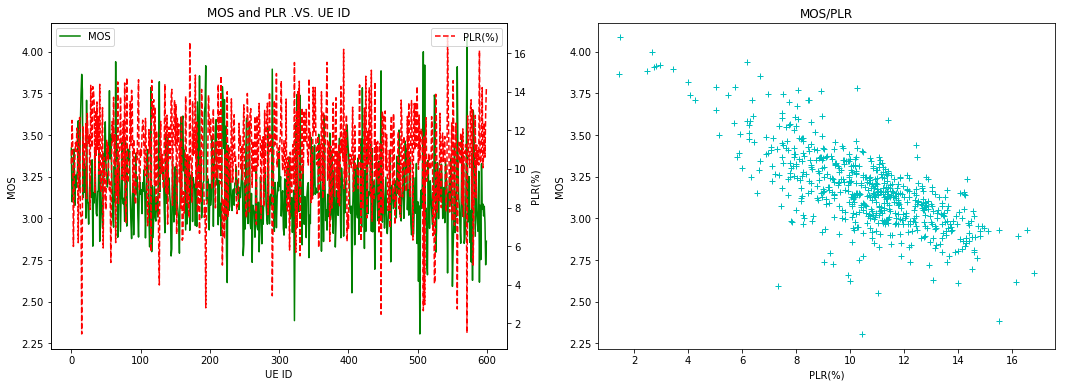

In [3]:
volte_process()

### FTP统计信息

In [4]:
# 获取取Log文件列表
def get_ftp_logs():
    file_path = os.path.join(log_path, "Application")  
    try: 
        os.chdir(file_path)
    except:
        print("The folder does not exist!")
        return
    
    ftp_get_logs = glob.glob("./cftp_get_[0-9]*.csv")
    ftp_put_logs = glob.glob("./cftp_put_[0-9]*.csv")

    return ftp_get_logs, ftp_put_logs
    
# 处理FTP GET/PUT文件    
def ftp_process():
    ftp_get_logs, ftp_put_logs = get_ftp_logs()
    
    if ftp_get_logs == []:
        print("No ftp get logs")
    else:
        ftp_get_process(ftp_get_logs)
        
    if ftp_put_logs == []:
        print("No ftp put logs")
    else:
        ftp_put_process(ftp_put_logs)

# 处理FTP GET文件
def ftp_get_process(ftp_get_logs):
    print("Start to analyze ftp get logs...")
    
    ftp_get_total_num = 0
    ftp_get_ue_id = []
    ftp_get_fail = []
    ftp_get_in_rate = []
    ftp_get_out_rate = []    
    
    for ftp_get_log in ftp_get_logs:
        p = re.search(r'_(\d+)_', ftp_get_log)
        ue_id = p.group(1)
        ftp_get_ue_id.append(ue_id)
        
        df_log = pd.read_csv(ftp_get_log, low_memory=False, skip_blank_lines=True, na_values=['nan'])     
        if (df_log['In Service'].sum() == 0):
            continue
        ftp_get_total_num += 1  
        
        df_log.dropna(axis=0, subset=['In Bits/s','Out Bits/s'], inplace=True)        
        
        in_rate = df_log['In Bits/s'].mean()
        out_rate = df_log['Out Bits/s'].mean()
        
        # 如果FTP_GET OUT/IN值不存在，说明FTP失败
        if np.isnan(in_rate): 
            ftp_get_fail.append(ue_id)
            
        ftp_get_in_rate.append(in_rate)
        ftp_get_out_rate.append(out_rate)
     
    ftp_get_fail_num = len(ftp_get_fail)
    
    ftp_get_in_rate_avg = np.nanmean(ftp_get_in_rate)
    ftp_get_out_rate_avg = np.nanmean(ftp_get_out_rate)
    
    print("FTP GET total number:", ftp_get_total_num)
    print("FTP GET fail number:", ftp_get_fail_num)
    print("FTP GET failed ue id:", ftp_get_fail)
    
    print("FTP GET DL Rate: {:.2f}bps".format(ftp_get_in_rate_avg))
    print("FTP GET UL Rate: {:.2f}bps".format(ftp_get_out_rate_avg))
    
# 处理FTP PUT文件
def ftp_put_process(ftp_put_logs):
    print("Start to analyze ftp put logs...")

    ftp_put_total_num = 0    
    ftp_put_ue_id = []
    ftp_put_fail = []    
    ftp_put_in_rate = []
    ftp_put_out_rate = []
    
    for ftp_put_log in ftp_put_logs:
        p = re.search(r'_(\d+)_', ftp_put_log)
        ue_id = p.group(1)
        ftp_put_ue_id.append(ue_id)
        
        df_log = pd.read_csv(ftp_put_log, low_memory=False, skip_blank_lines=True, na_values=['nan'])     
        if (df_log['In Service'].sum() == 0):
            continue
        ftp_put_total_num += 1     
        
        df_log.dropna(axis=0, subset=['In Bits/s','Out Bits/s'], inplace=True)        
        
        in_rate = df_log['In Bits/s'].mean()
        out_rate = df_log['Out Bits/s'].mean()
        
        # 如果FTP_PUT OUT/IN值不存在，说明FTP失败
        if np.isnan(in_rate): 
            ftp_put_fail.append(ue_id)
            
        ftp_put_in_rate.append(in_rate)
        ftp_put_out_rate.append(out_rate)
     
    ftp_put_fail_num = len(ftp_put_fail)
    
    ftp_put_in_rate_avg = np.nanmean(ftp_put_in_rate)
    ftp_put_out_rate_avg = np.nanmean(ftp_put_out_rate)
    
    print("FTP PUT total number:", ftp_put_total_num)
    print("FTP PUT fail number:", ftp_put_fail_num)
    print("FTP PUT failed ue id:", ftp_put_fail)
    
    print("FTP PUT DL Rate: {:.2f}bps".format(ftp_put_in_rate_avg))
    print("FTP PUT UL Rate: {:.2f}bps".format(ftp_put_out_rate_avg))

In [5]:
ftp_process()

Start to analyze ftp get logs...
FTP GET total number: 0
FTP GET fail number: 0
FTP GET failed ue id: []
FTP GET DL Rate: nanbps
FTP GET UL Rate: nanbps
Start to analyze ftp put logs...
FTP PUT total number: 0
FTP PUT fail number: 0
FTP PUT failed ue id: []
FTP PUT DL Rate: nanbps
FTP PUT UL Rate: nanbps


### UDP统计信息

In [6]:
# 获取取Log文件列表
def get_udp_logs():
    file_path = os.path.join(log_path, "Application")  
    try: 
        os.chdir(file_path)
    except:
        print("The folder does not exist!")
        return
    
    dl_udp_logs = glob.glob("./DL_UDP_[0-9]*.csv")
    ul_udp_logs = glob.glob("./UL_UDP_[0-9]*.csv")

    return dl_udp_logs, ul_udp_logs
    
# 分别处理DL/UL UDP LOG文件    
def udp_process():
    dl_udp_logs, ul_udp_logs = get_udp_logs()
    
    if dl_udp_logs == []:
        print("No dl udp logs")
    else:
        dl_udp_process(dl_udp_logs)
        
    if ul_udp_logs == []:
        print("No ul udp logs")
    else:
        ul_udp_process(ul_udp_logs)
    
# UDP LOG文件处理公共函数
def log_process(udp_logs):
    udp_total_num = 0    
    udp_ue_id = []
    udp_fail = []
    udp_rate = []       
    
    for udp_log in udp_logs:
        p = re.search(r'_(\d+)_', udp_log)
        ue_id = p.group(1)
        udp_ue_id.append(ue_id)        

        df_log = pd.read_csv(udp_log, low_memory=False, skip_blank_lines=True, na_values=['nan'])     
        if (df_log['In Service'].sum() == 0):
            continue
        udp_total_num += 1            
               
        df_log.dropna(axis=0, subset=['Out Bits/s'], inplace=True)        

        out_rate = df_log['Out Bits/s'].mean()
        
        # 如果UDP OUT值不存在，说明UDP失败
        if np.isnan(out_rate): 
            udp_fail.append(ue_id)
            
        udp_rate.append(out_rate)
     
    udp_fail_num = len(udp_fail)
    udp_rate_avg = np.nanmean(udp_rate)
    
    return [udp_total_num, udp_fail_num, udp_fail, udp_rate_avg]
    
# 处理DL UDP文件
def dl_udp_process(dl_udp_logs):
    print("Start to analyze dl udp logs...")
    
    dl_udp_result_list = log_process(dl_udp_logs)
    
    print("DL UDP total number:", dl_udp_result_list[0])
    print("DL UDP fail number:", dl_udp_result_list[1])
    print("DL UDP failed ue id:", dl_udp_result_list[2])

    print("DL UDP Rate: {:.2f}bps".format(dl_udp_result_list[3]))
    
# 处理UL UDP文件
def ul_udp_process(ul_udp_logs):
    print("Start to analyze ul udp logs...")
    
    ul_udp_result_list = log_process(ul_udp_logs)
    
    print("UL UDP total number:", ul_udp_result_list[0])
    print("UL UDP fail number:", ul_udp_result_list[1])
    print("UL UDP failed ue id:", ul_udp_result_list[2])
    print("UL UDP Rate: {:.2f}bps".format(ul_udp_result_list[3]))

In [7]:
udp_process()

No dl udp logs
Start to analyze ul udp logs...
UL UDP total number: 0
UL UDP fail number: 0
UL UDP failed ue id: []
UL UDP Rate: nanbps
